In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
from collections import Counter
from sklearn.model_selection import  GroupKFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import polars as pl

In [2]:
np.random.seed(42)

In [3]:
class Config:
    TRAIN_PATH = '/kaggle/input/predict-student-performance-from-game-play/train.csv'
    TRAIN_LABELS = '/kaggle/input/predict-student-performance-from-game-play/train_labels.csv'

In [4]:
def q2l(x):
    if x <= 3:
        return '0-4'
    if x <= 13:
        return '5-12'
    return '13-22'

In [5]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = ['page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
        'hover_duration', 'elapsed_time_diff']
event_features =  ['checkpoint_click','cutscene_click', 'person_click', 'navigate_click',
                   'observation_click', 'notification_click', 'object_click',
                   'object_hover', 'map_hover', 'map_click', 'notebook_click']
room_features = ['historicalsociety',
          'kohlcenter',
          'capitol_0',
          'humanecology',
          'drycleaner',
          'library',
          'capitol_1',
          'wildlife',
          'flaghouse','capitol_2']
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']

name_features = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']
room_events = ['checkpoint_library',
 'map_click_library',
 'navigate_click_library',
 'notification_click_library',
 'notebook_click_library',
 'cutscene_click_library',
 'person_click_library',
 'observation_click_library',
 'object_hover_library',
 'map_hover_library',
 'object_click_library',
 'notebook_click_capitol_1',
 'cutscene_click_capitol_1',
 'person_click_capitol_1',
 'notification_click_capitol_1',
 'observation_click_capitol_1',
 'map_click_capitol_1',
 'navigate_click_capitol_1',
 'object_click_capitol_1',
 'checkpoint_capitol_1',
 'map_hover_capitol_1',
 'object_hover_capitol_1',
 'map_click_historicalsociety',
 'object_click_historicalsociety',
 'map_hover_historicalsociety',
 'person_click_historicalsociety',
 'notification_click_historicalsociety',
 'cutscene_click_historicalsociety',
 'observation_click_historicalsociety',
 'navigate_click_historicalsociety',
 'checkpoint_historicalsociety',
 'notebook_click_historicalsociety',
 'object_hover_historicalsociety',
 'person_click_flaghouse',
 'notebook_click_flaghouse',
 'observation_click_flaghouse',
 'map_hover_flaghouse',
 'checkpoint_flaghouse',
 'notification_click_flaghouse',
 'map_click_flaghouse',
 'object_hover_flaghouse',
 'object_click_flaghouse',
 'cutscene_click_flaghouse',
 'navigate_click_flaghouse',
 'map_click_wildlife',
 'notification_click_wildlife',
 'cutscene_click_wildlife',
 'map_hover_wildlife',
 'checkpoint_wildlife',
 'object_click_wildlife',
 'observation_click_wildlife',
 'navigate_click_wildlife',
 'object_hover_wildlife',
 'person_click_wildlife',
 'notebook_click_wildlife',
 'checkpoint_drycleaner',
 'observation_click_drycleaner',
 'person_click_drycleaner',
 'notebook_click_drycleaner',
 'map_hover_drycleaner',
 'map_click_drycleaner',
 'object_hover_drycleaner',
 'cutscene_click_drycleaner',
 'notification_click_drycleaner',
 'navigate_click_drycleaner',
 'object_click_drycleaner',
 'navigate_click_capitol_2',
 'object_hover_capitol_2',
 'object_click_capitol_2',
 'cutscene_click_capitol_2',
 'observation_click_capitol_2',
 'notebook_click_capitol_2',
 'checkpoint_capitol_2',
 'notification_click_capitol_2',
 'person_click_capitol_2',
 'map_hover_capitol_2',
 'map_click_capitol_2',
 'cutscene_click_humanecology',
 'checkpoint_humanecology',
 'map_hover_humanecology',
 'object_hover_humanecology',
 'observation_click_humanecology',
 'notebook_click_humanecology',
 'map_click_humanecology',
 'navigate_click_humanecology',
 'person_click_humanecology',
 'notification_click_humanecology',
 'object_click_humanecology',
 'cutscene_click_capitol_0',
 'notebook_click_capitol_0',
 'checkpoint_capitol_0',
 'navigate_click_capitol_0',
 'object_hover_capitol_0',
 'map_click_capitol_0',
 'person_click_capitol_0',
 'object_click_capitol_0',
 'observation_click_capitol_0',
 'map_hover_capitol_0',
 'notification_click_capitol_0',
 'object_click_kohlcenter',
 'observation_click_kohlcenter',
 'notebook_click_kohlcenter',
 'person_click_kohlcenter',
 'notification_click_kohlcenter',
 'checkpoint_kohlcenter',
 'map_click_kohlcenter',
 'cutscene_click_kohlcenter',
 'object_hover_kohlcenter',
 'navigate_click_kohlcenter',
 'map_hover_kohlcenter']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [6]:
columns = [
    (pl.col('level') - pl.col('level').shift(1)).over('session_id','level_group').alias('level_shift'),
    pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    (
        (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_x_diff") 
    ),
    (
        (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
         .abs()
         .over(["session_id", "level_group"])
        .alias("location_y_diff") 
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None"),
    pl.col('room_fqid').str.split('.').arr[1].alias('main_room')
]

In [7]:
df = (pl.read_csv(Config.TRAIN_PATH)
      .drop(["fullscreen", "hq", "music"])
      .with_columns(columns))
df=df.with_columns((pl.col('event_name') + '_' + pl.col('main_room')).alias('room_event'))

In [8]:
df1 = df.filter(pl.col("level_group")=='0-4')
df2 = df.filter(pl.col("level_group")=='5-12')
# df2 = df.filter((pl.col("level_group")=='5-12')|(pl.col("level_group")=='0-4'))
df3 = df.filter(pl.col("level_group")=='13-22')
# df3 = df.clone()
df1.shape,df2.shape,df3.shape

((1994687, 23), (4433127, 23), (6746397, 23))

In [9]:
def time_feature(train):
    train["year"] = train["session_id"].apply(lambda x: int(str(x)[:2])).astype(np.uint8)
    train["month"] = train["session_id"].apply(lambda x: int(str(x)[2:4])+1).astype(np.uint8)
    train["day"] = train["session_id"].apply(lambda x: int(str(x)[4:6])).astype(np.uint8)
    train["hour"] = train["session_id"].apply(lambda x: int(str(x)[6:8])).astype(np.uint8)
    train["minute"] = train["session_id"].apply(lambda x: int(str(x)[8:10])).astype(np.uint8)
    train["second"] = train["session_id"].apply(lambda x: int(str(x)[10:12])).astype(np.uint8)


    return train

In [10]:
def feature_engineer(x, grp):
    aggs = [
#     pl.col('level_shift').min().alias('level_shift_min'),
#     pl.col('level_shift').apply(lambda x: x < 0).sum().alias('n_level_shift_negative'),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
#         .mean().alias(f"elapsed_time_diff_level_shift_negative_mean"),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
#         .std().alias(f"elapsed_time_diff_level_shift_negative_std"), 
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
#         .min().alias(f"elapsed_time_diff_level_shift_negative_min"),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") < 0)\
#         .min().alias(f"elapsed_time_diff_level_shift_negative_max"),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
#         .mean().alias(f"elapsed_time_diff_level_shift_positive_mean"),
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
#         .std().alias(f"elapsed_time_diff_level_shift_positive_std"), 
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
#         .min().alias(f"elapsed_time_diff_level_shift_positive_min"), 
#     pl.col("elapsed_time_diff").filter(pl.col("level_shift") >= 0)\
#         .min().alias(f"elapsed_time_diff_level_shift_positive_max"), 
    (pl.col('elapsed_time').apply(lambda x: x.max() - x.min())).alias('duration'),
    *[pl.col("elapsed_time").filter(pl.col("level") == i)
      .apply(lambda x: x.max() - x.min() if len(x) > 0 else 0)
      .alias(f'duration_level_{i}') for i in range(0,23)],
    # *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique") for c in CATS],
    (pl.col('text_fqid').is_null().count().alias('text_fqid_null')),
    (pl.col('hover_duration').mean()
     .alias(f"hover_duration_mean")),
    (pl.col('hover_duration').std()
     .alias(f"hover_duration_std")),
    (pl.col('hover_duration').max()
     .alias(f"hover_duration_max")),
    (pl.col('hover_duration').min()
     .alias(f"hover_duration_min")),
#     *[pl.col("hover_duration").filter(pl.col("level") == i).sum()
#       .alias(f'hover_duration_level_{i}') for i in range(0,23)],
    (pl.col('elapsed_time_diff').quantile(0.1, "nearest")
     .alias(f"elapsed_time_diff_q1")),
    (pl.col('elapsed_time_diff').quantile(0.2, "nearest")
     .alias(f"elapsed_time_diff_q2")),
    (pl.col('elapsed_time_diff').quantile(0.3, "nearest")
     .alias(f"elapsed_time_diff_q3")),
    (pl.col('elapsed_time_diff').quantile(0.4, "nearest")
     .alias(f"elapsed_time_diff_q4")),
    (pl.col('elapsed_time_diff').quantile(0.6, "nearest")
     .alias(f"elapsed_time_diff_q6")),
    (pl.col('elapsed_time_diff').quantile(0.7, "nearest")
     .alias(f"elapsed_time_diff_q7")),
    (pl.col('elapsed_time_diff').quantile(0.8, "nearest")
     .alias(f"elapsed_time_diff_q8")),
    (pl.col('elapsed_time_diff').quantile(0.9, "nearest")
     .alias(f"elapsed_time_diff_q9")),
    (pl.col('elapsed_time_diff').mean()
     .alias(f"elapsed_time_diff_mean")),
    (pl.col('elapsed_time_diff').std()
     .alias(f"elapsed_time_diff_std")),
    (pl.col('elapsed_time_diff').max()
     .alias(f"elapsed_time_diff_max")),
    (pl.col('elapsed_time_diff').min()
     .alias(f"elapsed_time_diff_min")),
    *[pl.col("room_event").filter(pl.col("room_event") == c)
        .count().alias(f"{c}_room_event_counts") 
      for c in room_events],
    *[pl.col("event_name").filter(pl.col("event_name") == c)
        .count().alias(f"{c}_event_counts") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.1, "nearest").alias(f"elapsed_time_diff_{c}_q1") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.2, "nearest").alias(f"elapsed_time_diff_{c}_q2") 
      for c in event_features ],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.3, "nearest").alias(f"elapsed_time_diff_{c}_q3") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.4, "nearest").alias(f"elapsed_time_diff_{c}_q4") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.6, "nearest").alias(f"elapsed_time_diff_{c}_q6") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.7, "nearest").alias(f"elapsed_time_diff_{c}_q7") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.8, "nearest").alias(f"elapsed_time_diff_{c}_q8") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .quantile(0.9, "nearest").alias(f"elapsed_time_diff_{c}_q9") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in event_features],
    *[pl.col("elapsed_time_diff").filter(pl.col("event_name") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in event_features],
    
    *[pl.col("fqid").filter(pl.col("fqid") == c)
        .count().alias(f"{c}_fqid_counts") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.1, "nearest").alias(f"elapsed_time_diff_{c}_q1") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.2, "nearest").alias(f"elapsed_time_diff_{c}_q2") 
      for c in fqid_lists ],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.3, "nearest").alias(f"elapsed_time_diff_{c}_q3") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.4, "nearest").alias(f"elapsed_time_diff_{c}_q4") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.6, "nearest").alias(f"elapsed_time_diff_{c}_q6") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.7, "nearest").alias(f"elapsed_time_diff_{c}_q7") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.8, "nearest").alias(f"elapsed_time_diff_{c}_q8") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .quantile(0.9, "nearest").alias(f"elapsed_time_diff_{c}_q9") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in fqid_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in fqid_lists],
    
    *[pl.col("text_fqid").filter(pl.col("text_fqid") == c)
        .count().alias(f"{c}_text_fqid_counts")
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.1, "nearest").alias(f"elapsed_time_diff_{c}_q1") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.2, "nearest").alias(f"elapsed_time_diff_{c}_q2") 
      for c in text_lists ],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.3, "nearest").alias(f"elapsed_time_diff_{c}_q3") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.4, "nearest").alias(f"elapsed_time_diff_{c}_q4") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.6, "nearest").alias(f"elapsed_time_diff_{c}_q6") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.7, "nearest").alias(f"elapsed_time_diff_{c}_q7") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.8, "nearest").alias(f"elapsed_time_diff_{c}_q8") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .quantile(0.9, "nearest").alias(f"elapsed_time_diff_{c}_q9") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .mean().alias(f"elapsed_time_diff_{c}_mean") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .std().alias(f"elapsed_time_diff_{c}_std") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .min().alias(f"elapsed_time_diff_{c}_min") 
      for c in text_lists],
    *[pl.col("elapsed_time_diff").filter(pl.col("text_fqid") == c)
        .max().alias(f"elapsed_time_diff_{c}_max") 
      for c in text_lists],

    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).mean().alias(f"{c}_ET_mean_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).std().alias(f"{c}_ET_std_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).max().alias(f"{c}_ET_max_x") for c in event_features],
    *[pl.col("location_x_diff").filter(pl.col("event_name")==c).min().alias(f"{c}_ET_min_x") for c in event_features]        
]
    
    df = x.groupby(["session_id"], maintain_order=True).agg(aggs).sort("session_id")
    for col1 in event_features:
        for col2 in event_features:
            if col1!=col2:
                
                df = df.with_columns([pl.struct([f'{col1}_event_counts',f'{col2}_event_counts'])\
                                          .apply(lambda x: x[f'{col1}_event_counts']/(x[f'{col1}_event_counts']+x[f'{col2}_event_counts']+1))\
                                          .alias(f'{col1}/({col1}+{col2})')])
    return df.to_pandas()

In [11]:
%%time
df1 = feature_engineer(df1, grp='0-4')
print('df1 done',df1.shape)
df2 = feature_engineer(df2, grp='5-12')
print('df2 done',df2.shape)
df3 = feature_engineer(df3, grp='13-22')
print('df3 done',df3.shape)

df1 done (11779, 3738)
df2 done (11779, 3738)
df3 done (11779, 3738)
CPU times: user 3min 26s, sys: 3.66 s, total: 3min 30s
Wall time: 2min 5s


In [12]:
df1 = time_feature(df1)
df2 = time_feature(df2)
df3 = time_feature(df3)

In [13]:
null1 = df1.isnull().sum().sort_values(ascending=False) / len(df1)
null2 = df2.isnull().sum().sort_values(ascending=False) / len(df1)
null3 = df3.isnull().sum().sort_values(ascending=False) / len(df1)

drop1 = list(null1[null1>0.9].index)
drop2 = list(null2[null2>0.9].index)
drop3 = list(null3[null3>0.9].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1.columns:
    if df1[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2.columns:
    if df2[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3.columns:
    if df3[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")

2447 1908 1704
duration_level_5
duration_level_6
duration_level_7
duration_level_8
duration_level_9
duration_level_10
duration_level_11
duration_level_12
duration_level_13
duration_level_14
duration_level_15
duration_level_16
duration_level_17
duration_level_18
duration_level_19
duration_level_20
duration_level_21
duration_level_22
elapsed_time_diff_min
checkpoint_library_room_event_counts
map_click_library_room_event_counts
navigate_click_library_room_event_counts
notification_click_library_room_event_counts
notebook_click_library_room_event_counts
cutscene_click_library_room_event_counts
person_click_library_room_event_counts
observation_click_library_room_event_counts
object_hover_library_room_event_counts
map_hover_library_room_event_counts
object_click_library_room_event_counts
notebook_click_capitol_1_room_event_counts
cutscene_click_capitol_1_room_event_counts
person_click_capitol_1_room_event_counts
notification_click_capitol_1_room_event_counts
observation_click_capitol_1_room

In [14]:
df1 = df1.set_index('session_id')
df2 = df2.set_index('session_id')
df3 = df3.set_index('session_id')

FEATURES1 = [c for c in df1.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 986 1610 1865 features
We will train with 11779 users info


In [15]:
import xgboost as xgb
xgb.__version__

'1.6.2'

In [16]:
targets = pd.read_csv(Config.TRAIN_LABELS)
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
print(targets.shape)

(212022, 4)


In [17]:
from collections import defaultdict

In [18]:
target_pivot = targets.pivot(index='session', columns='q',values ='correct').reset_index()
target_pivot.rename(columns={'session':'session_id'},inplace=True)
target_pivot.set_index('session_id',inplace=True)

In [19]:
from lightgbm import LGBMClassifier
xgb_params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': 9999,
        'early_stopping_rounds': 90,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'seed': 42
    }
lgb_params = {
    'learning_rate': 0.015,
    'max_depth': 4,
    'n_estimators': 9999,
    'subsample':0.8,
    'colsample_bytree': 0.5,
    'reg_alpha': 8,
    'device':'gpu',
    'seed': 42
}

In [20]:
%%time
gkf = GroupKFold(n_splits=5)
oof_xgb = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS, columns=[f'meta_{i}' for i in range(1, 19)])
#models = {}
best_iteration_xgb = defaultdict(list)
importance_dict = {}
use_merge=False
model_type='xgboost'
feats = {}
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        if use_merge:
            df = df2.join(target_pivot[[i for i in range(1,4)]])
            FEATURES = FEATURES2 + [i for i in range(1,4)]
        else:
            df = df2
            FEATURES = FEATURES2
    elif t<=22: 
        grp = '13-22'
        if use_merge:
            df = df3.join(target_pivot[[i for i in range(1,14)]])
            FEATURES = FEATURES3 + [i for i in range(1,14)]
        else:
            df = df3
            FEATURES = FEATURES3
   
    print('#'*25)
    print('### question', t, 'with features', len(FEATURES))
    print('#'*25)
    df.fillna(0, inplace=True)
    
    feature_importance_df = pd.DataFrame()
    # COMPUTE CV SCORE WITH 5 GROUP K FOLD
    for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
        
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        if model_type=='xgboost':
        # TRAIN MODEL        
            clf =  XGBClassifier(**xgb_params)
            clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                    eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                    verbose=100)
            print(i+1, ', ', end='')
            best_iteration_xgb[str(t)].append(clf.best_ntree_limit)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = FEATURES
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            # SAVE MODEL, PREDICT VALID OOF
            oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
            
        if model_type=='lightgbm':
            clf = LGBMClassifier(**lgb_params)
            clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                    eval_set=[(valid_x[FEATURES].astype('float32'), valid_y['correct'])],
                    early_stopping_rounds=90,
                    verbose=100)
            print(i+1, ', ', end='')
            best_iteration_xgb[str(t)].append(clf.best_iteration_)

            fold_importance_df = pd.DataFrame()
            fold_importance_df["feature"] = FEATURES
            fold_importance_df["importance"] = clf.feature_importances_
            fold_importance_df["fold"] = i + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
            oof_xgb.loc[valid_users, f'meta_{t}'] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()
    feature_importance_df = feature_importance_df.groupby(['feature'])['importance'].agg(['mean']).sort_values(by='mean', ascending=False)
    feats[t] = feature_importance_df
    display(feature_importance_df.head(10))

#########################
### question 1 with features 986
#########################
[0]	validation_0-logloss:0.68745
[100]	validation_0-logloss:0.51378
[200]	validation_0-logloss:0.49517
[300]	validation_0-logloss:0.49032
[400]	validation_0-logloss:0.48919
[500]	validation_0-logloss:0.48860
[600]	validation_0-logloss:0.48847
[635]	validation_0-logloss:0.48845
1 , [0]	validation_0-logloss:0.68732
[100]	validation_0-logloss:0.50781
[200]	validation_0-logloss:0.48963
[300]	validation_0-logloss:0.48615
[400]	validation_0-logloss:0.48575
[499]	validation_0-logloss:0.48622
2 , [0]	validation_0-logloss:0.68785
[100]	validation_0-logloss:0.53791
[200]	validation_0-logloss:0.52479
[300]	validation_0-logloss:0.52192
[400]	validation_0-logloss:0.52029
[500]	validation_0-logloss:0.52045
[513]	validation_0-logloss:0.52063
3 , [0]	validation_0-logloss:0.68744
[100]	validation_0-logloss:0.52352
[200]	validation_0-logloss:0.50765
[300]	validation_0-logloss:0.50424
[400]	validation_0-logloss:0.50355
[

,mean
feature,
plaque_fqid_counts,0.009063
object_click_kohlcenter_room_event_counts,0.008359
object_click/(object_click+checkpoint_click),0.007940
object_click/(object_click+notification_click),0.006316
elapsed_time_diff_cs_q4,0.006315
elapsed_time_diff_chap1_finale_c_q8,0.006203
elapsed_time_diff_tunic.historicalsociety.collection.cs_q4,0.005495
object_click_event_counts,0.005222
elapsed_time_diff_tunic.historicalsociety.collection.cs_q3,0.005153


#########################
### question 2 with features 986
#########################
[0]	validation_0-logloss:0.67495
[100]	validation_0-logloss:0.13417
[200]	validation_0-logloss:0.08839
[300]	validation_0-logloss:0.08253
[400]	validation_0-logloss:0.08164
[500]	validation_0-logloss:0.08157
[572]	validation_0-logloss:0.08171
1 , [0]	validation_0-logloss:0.67512
[100]	validation_0-logloss:0.13883
[200]	validation_0-logloss:0.09571
[300]	validation_0-logloss:0.09004
[400]	validation_0-logloss:0.08910
[481]	validation_0-logloss:0.08939
2 , [0]	validation_0-logloss:0.67511
[100]	validation_0-logloss:0.14449
[200]	validation_0-logloss:0.10335
[300]	validation_0-logloss:0.09794
[400]	validation_0-logloss:0.09647
[500]	validation_0-logloss:0.09626
[556]	validation_0-logloss:0.09662
3 , [0]	validation_0-logloss:0.67503
[100]	validation_0-logloss:0.13961
[200]	validation_0-logloss:0.09629
[300]	validation_0-logloss:0.09149
[400]	validation_0-logloss:0.09159
[424]	validation_0-logloss:0.09165
4

,mean
feature,
object_click_event_counts,0.004907
object_click/(object_click+checkpoint_click),0.004579
elapsed_time_diff_tunic.historicalsociety.collection.gramps.found_q3,0.004538
elapsed_time_diff_groupconvo_q3,0.003867
duration_level_4,0.003743
elapsed_time_diff_chap1_finale_c_q6,0.003616
elapsed_time_diff_groupconvo_q4,0.003315
object_click/(object_click+person_click),0.003276
person_click/(person_click+object_click),0.003214


#########################
### question 3 with features 986
#########################
[0]	validation_0-logloss:0.67833
[100]	validation_0-logloss:0.25479
[200]	validation_0-logloss:0.22630
[300]	validation_0-logloss:0.22344
[400]	validation_0-logloss:0.22347
[451]	validation_0-logloss:0.22411
1 , [0]	validation_0-logloss:0.67820
[100]	validation_0-logloss:0.24510
[200]	validation_0-logloss:0.21558
[300]	validation_0-logloss:0.21331
[400]	validation_0-logloss:0.21379
[418]	validation_0-logloss:0.21390
2 , [0]	validation_0-logloss:0.67839
[100]	validation_0-logloss:0.25951
[200]	validation_0-logloss:0.23084
[300]	validation_0-logloss:0.22540
[400]	validation_0-logloss:0.22481
[454]	validation_0-logloss:0.22485
3 , [0]	validation_0-logloss:0.67830
[100]	validation_0-logloss:0.25493
[200]	validation_0-logloss:0.22645
[300]	validation_0-logloss:0.22339
[390]	validation_0-logloss:0.22376
4 , [0]	validation_0-logloss:0.67830
[100]	validation_0-logloss:0.25988
[200]	validation_0-logloss:0.23387

,mean
feature,
object_click/(object_click+checkpoint_click),0.004519
object_click_event_counts,0.004256
text_fqid_null,0.003309
elapsed_time_diff_chap1_finale_c_q7,0.003072
object_click/(object_click+notification_click),0.003039
elapsed_time_diff_chap1_finale_c_q6,0.002974
notebook_click_event_counts,0.002854
object_click/(object_click+map_click),0.002844
object_click_kohlcenter_room_event_counts,0.002743


#########################
### question 4 with features 1610
#########################
[0]	validation_0-logloss:0.68470
[100]	validation_0-logloss:0.43110
[200]	validation_0-logloss:0.41384
[300]	validation_0-logloss:0.41120
[400]	validation_0-logloss:0.41139
[412]	validation_0-logloss:0.41151
1 , [0]	validation_0-logloss:0.68476
[100]	validation_0-logloss:0.44224
[200]	validation_0-logloss:0.42726
[300]	validation_0-logloss:0.42618
[400]	validation_0-logloss:0.42680
[403]	validation_0-logloss:0.42677
2 , [0]	validation_0-logloss:0.68461
[100]	validation_0-logloss:0.44713
[200]	validation_0-logloss:0.43286
[300]	validation_0-logloss:0.43122
[400]	validation_0-logloss:0.43138
[413]	validation_0-logloss:0.43138
3 , [0]	validation_0-logloss:0.68472
[100]	validation_0-logloss:0.43913
[200]	validation_0-logloss:0.42322
[300]	validation_0-logloss:0.42166
[338]	validation_0-logloss:0.42232
4 , [0]	validation_0-logloss:0.68463
[100]	validation_0-logloss:0.44228
[200]	validation_0-logloss:0.4260

,mean
feature,
elapsed_time_diff_worker_q3,0.017696
elapsed_time_diff_worker_q4,0.016960
elapsed_time_diff_person_click_q3,0.015828
elapsed_time_diff_person_click_q4,0.011719
elapsed_time_diff_tunic.library.frontdesk.worker.wells_q4,0.010965
elapsed_time_diff_tunic.library.frontdesk.worker.wells_q3,0.009606
elapsed_time_diff_worker_q2,0.008306
elapsed_time_diff_tunic.drycleaner.frontdesk.worker.hub_q3,0.007829
elapsed_time_diff_person_click_q2,0.007600


#########################
### question 5 with features 1610
#########################
[0]	validation_0-logloss:0.69149
[100]	validation_0-logloss:0.62924
[200]	validation_0-logloss:0.61903
[300]	validation_0-logloss:0.61587
[400]	validation_0-logloss:0.61334
[500]	validation_0-logloss:0.61291
[528]	validation_0-logloss:0.61306
1 , [0]	validation_0-logloss:0.69149
[100]	validation_0-logloss:0.63800
[200]	validation_0-logloss:0.63092
[300]	validation_0-logloss:0.62969
[400]	validation_0-logloss:0.62922
[474]	validation_0-logloss:0.62958
2 , [0]	validation_0-logloss:0.69157
[100]	validation_0-logloss:0.64251
[200]	validation_0-logloss:0.63589
[300]	validation_0-logloss:0.63414
[400]	validation_0-logloss:0.63416
[439]	validation_0-logloss:0.63449
3 , [0]	validation_0-logloss:0.69139
[100]	validation_0-logloss:0.62889
[200]	validation_0-logloss:0.61943
[300]	validation_0-logloss:0.61757
[400]	validation_0-logloss:0.61655
[500]	validation_0-logloss:0.61642
[573]	validation_0-logloss:0.61614


,mean
feature,
navigate_click_event_counts,0.013688
text_fqid_null,0.009755
navigate_click/(navigate_click+checkpoint_click),0.008071
map_click/(map_click+checkpoint_click),0.006087
object_click/(object_click+checkpoint_click),0.004966
navigate_click_historicalsociety_room_event_counts,0.004456
object_click_event_counts,0.004086
elapsed_time_diff_person_click_q2,0.003688
toentry_fqid_counts,0.003625


#########################
### question 6 with features 1610
#########################
[0]	validation_0-logloss:0.68631
[100]	validation_0-logloss:0.49402
[200]	validation_0-logloss:0.47860
[300]	validation_0-logloss:0.47388
[400]	validation_0-logloss:0.47165
[500]	validation_0-logloss:0.47033
[579]	validation_0-logloss:0.47056
1 , [0]	validation_0-logloss:0.68622
[100]	validation_0-logloss:0.48417
[200]	validation_0-logloss:0.46954
[300]	validation_0-logloss:0.46680
[400]	validation_0-logloss:0.46654
[442]	validation_0-logloss:0.46626
2 , [0]	validation_0-logloss:0.68663
[100]	validation_0-logloss:0.51309
[200]	validation_0-logloss:0.50774
[300]	validation_0-logloss:0.50784
[305]	validation_0-logloss:0.50786
3 , [0]	validation_0-logloss:0.68625
[100]	validation_0-logloss:0.48643
[200]	validation_0-logloss:0.47225
[300]	validation_0-logloss:0.46827
[400]	validation_0-logloss:0.46743
[500]	validation_0-logloss:0.46714
[551]	validation_0-logloss:0.46718
4 , [0]	validation_0-logloss:0.6862

,mean
feature,
text_fqid_null,0.009618
navigate_click_event_counts,0.007322
navigate_click/(navigate_click+checkpoint_click),0.006551
duration_level_11,0.005779
map_click/(map_click+checkpoint_click),0.004555
journals.pic_0.next_fqid_counts,0.004403
journals.pic_1.next_fqid_counts,0.003464
object_hover_event_counts,0.003411
navigate_click_historicalsociety_room_event_counts,0.002853


#########################
### question 7 with features 1610
#########################
[0]	validation_0-logloss:0.68842
[100]	validation_0-logloss:0.55266
[200]	validation_0-logloss:0.54272
[300]	validation_0-logloss:0.53963
[400]	validation_0-logloss:0.53827
[500]	validation_0-logloss:0.53735
[600]	validation_0-logloss:0.53700
[681]	validation_0-logloss:0.53726
1 , [0]	validation_0-logloss:0.68818
[100]	validation_0-logloss:0.54053
[200]	validation_0-logloss:0.52810
[300]	validation_0-logloss:0.52589
[400]	validation_0-logloss:0.52527
[500]	validation_0-logloss:0.52488
[600]	validation_0-logloss:0.52538
[635]	validation_0-logloss:0.52552
2 , [0]	validation_0-logloss:0.68798
[100]	validation_0-logloss:0.54454
[200]	validation_0-logloss:0.53316
[300]	validation_0-logloss:0.53057
[400]	validation_0-logloss:0.52950
[500]	validation_0-logloss:0.52902
[600]	validation_0-logloss:0.52869
[660]	validation_0-logloss:0.52899
3 , [0]	validation_0-logloss:0.68813
[100]	validation_0-logloss:0.54408


,mean
feature,
text_fqid_null,0.007371
navigate_click_event_counts,0.005442
map_click/(map_click+checkpoint_click),0.005006
navigate_click/(navigate_click+checkpoint_click),0.004709
elapsed_time_diff_person_click_q2,0.003551
elapsed_time_diff_archivist_q2,0.002862
notification_click/(notification_click+navigate_click),0.002711
map_click_event_counts,0.002694
elapsed_time_diff_worker_q3,0.002607


#########################
### question 8 with features 1610
#########################
[0]	validation_0-logloss:0.69146
[100]	validation_0-logloss:0.64525
[200]	validation_0-logloss:0.64122
[300]	validation_0-logloss:0.64079
[349]	validation_0-logloss:0.64149
1 , [0]	validation_0-logloss:0.69174
[100]	validation_0-logloss:0.65455
[200]	validation_0-logloss:0.65353
[273]	validation_0-logloss:0.65369
2 , [0]	validation_0-logloss:0.69174
[100]	validation_0-logloss:0.65421
[200]	validation_0-logloss:0.65343
[242]	validation_0-logloss:0.65376
3 , [0]	validation_0-logloss:0.69179
[100]	validation_0-logloss:0.65956
[200]	validation_0-logloss:0.65952
[236]	validation_0-logloss:0.65956
4 , [0]	validation_0-logloss:0.69161
[100]	validation_0-logloss:0.64706
[200]	validation_0-logloss:0.64335
[300]	validation_0-logloss:0.64329
[333]	validation_0-logloss:0.64339
5 , 


,mean
feature,
text_fqid_null,0.004195
object_click/(object_click+checkpoint_click),0.004019
map_click/(map_click+checkpoint_click),0.003759
object_click_event_counts,0.002930
object_click/(object_click+notification_click),0.002239
elapsed_time_diff_tunic.historicalsociety.frontdesk.archivist.newspaper_q2,0.002188
elapsed_time_diff_person_click_q3,0.002119
elapsed_time_diff_worker_q3,0.001825
elapsed_time_diff_archivist_q2,0.001822


#########################
### question 9 with features 1610
#########################
[0]	validation_0-logloss:0.68792
[100]	validation_0-logloss:0.54500
[200]	validation_0-logloss:0.53640
[300]	validation_0-logloss:0.53501
[400]	validation_0-logloss:0.53486
[500]	validation_0-logloss:0.53506
[554]	validation_0-logloss:0.53518
1 , [0]	validation_0-logloss:0.68781
[100]	validation_0-logloss:0.53084
[200]	validation_0-logloss:0.51783
[300]	validation_0-logloss:0.51593
[346]	validation_0-logloss:0.51621
2 , [0]	validation_0-logloss:0.68798
[100]	validation_0-logloss:0.54734
[200]	validation_0-logloss:0.53721
[300]	validation_0-logloss:0.53462
[400]	validation_0-logloss:0.53301
[500]	validation_0-logloss:0.53251
[587]	validation_0-logloss:0.53311
3 , [0]	validation_0-logloss:0.68798
[100]	validation_0-logloss:0.54277
[200]	validation_0-logloss:0.53324
[300]	validation_0-logloss:0.53227
[394]	validation_0-logloss:0.53296
4 , [0]	validation_0-logloss:0.68776
[100]	validation_0-logloss:0.5289

,mean
feature,
text_fqid_null,0.009467
navigate_click_event_counts,0.007394
navigate_click/(navigate_click+checkpoint_click),0.006804
object_click_event_counts,0.005927
object_click/(object_click+checkpoint_click),0.004872
map_click_kohlcenter_room_event_counts,0.004340
elapsed_time_diff_person_click_q2,0.003637
journals.pic_1.next_fqid_counts,0.003454
map_click/(map_click+checkpoint_click),0.003056


#########################
### question 10 with features 1610
#########################
[0]	validation_0-logloss:0.69173
[100]	validation_0-logloss:0.64298
[200]	validation_0-logloss:0.63413
[300]	validation_0-logloss:0.63212
[400]	validation_0-logloss:0.63097
[500]	validation_0-logloss:0.63038
[600]	validation_0-logloss:0.63001
[640]	validation_0-logloss:0.63002
1 , [0]	validation_0-logloss:0.69172
[100]	validation_0-logloss:0.64649
[200]	validation_0-logloss:0.64109
[300]	validation_0-logloss:0.63950
[400]	validation_0-logloss:0.63862
[500]	validation_0-logloss:0.63826
[543]	validation_0-logloss:0.63848
2 , [0]	validation_0-logloss:0.69200
[100]	validation_0-logloss:0.65713
[200]	validation_0-logloss:0.65317
[300]	validation_0-logloss:0.65253
[400]	validation_0-logloss:0.65230
[500]	validation_0-logloss:0.65283
[512]	validation_0-logloss:0.65272
3 , [0]	validation_0-logloss:0.69176
[100]	validation_0-logloss:0.64509
[200]	validation_0-logloss:0.63969
[300]	validation_0-logloss:0.63908

,mean
feature,
object_click/(object_click+checkpoint_click),0.008824
text_fqid_null,0.008429
object_click_event_counts,0.006738
object_click/(object_click+notification_click),0.004994
object_click_historicalsociety_room_event_counts,0.003475
notification_click/(notification_click+object_click),0.003179
elapsed_time_diff_worker_q3,0.003080
elapsed_time_diff_tunic.drycleaner.frontdesk.worker.hub_q2,0.002907
duration_level_11,0.002627


#########################
### question 11 with features 1610
#########################
[0]	validation_0-logloss:0.69071
[100]	validation_0-logloss:0.61790
[200]	validation_0-logloss:0.61052
[300]	validation_0-logloss:0.60910
[400]	validation_0-logloss:0.60865
[500]	validation_0-logloss:0.60832
[537]	validation_0-logloss:0.60831
1 , [0]	validation_0-logloss:0.69078
[100]	validation_0-logloss:0.62395
[200]	validation_0-logloss:0.61836
[300]	validation_0-logloss:0.61657
[400]	validation_0-logloss:0.61602
[500]	validation_0-logloss:0.61528
[588]	validation_0-logloss:0.61569
2 , [0]	validation_0-logloss:0.69072
[100]	validation_0-logloss:0.62269
[200]	validation_0-logloss:0.61735
[300]	validation_0-logloss:0.61735
[352]	validation_0-logloss:0.61686
3 , [0]	validation_0-logloss:0.69052
[100]	validation_0-logloss:0.62089
[200]	validation_0-logloss:0.61544
[300]	validation_0-logloss:0.61289
[400]	validation_0-logloss:0.61275
[500]	validation_0-logloss:0.61227
[556]	validation_0-logloss:0.61290

,mean
feature,
object_click/(object_click+checkpoint_click),0.008118
text_fqid_null,0.006937
object_click_event_counts,0.006780
object_click/(object_click+notification_click),0.005937
navigate_click/(navigate_click+checkpoint_click),0.002543
object_click_historicalsociety_room_event_counts,0.002518
navigate_click_historicalsociety_room_event_counts,0.002384
elapsed_time_diff_cutscene_click_q7,0.002167
navigate_click_event_counts,0.002148


#########################
### question 12 with features 1610
#########################
[0]	validation_0-logloss:0.68283
[100]	validation_0-logloss:0.40374
[200]	validation_0-logloss:0.39013
[300]	validation_0-logloss:0.38836
[400]	validation_0-logloss:0.38818
[500]	validation_0-logloss:0.38829
[517]	validation_0-logloss:0.38839
1 , [0]	validation_0-logloss:0.68305
[100]	validation_0-logloss:0.41431
[200]	validation_0-logloss:0.40372
[300]	validation_0-logloss:0.40332
[355]	validation_0-logloss:0.40381
2 , [0]	validation_0-logloss:0.68276
[100]	validation_0-logloss:0.39682
[200]	validation_0-logloss:0.38401
[300]	validation_0-logloss:0.38335
[400]	validation_0-logloss:0.38262
[491]	validation_0-logloss:0.38364
3 , [0]	validation_0-logloss:0.68286
[100]	validation_0-logloss:0.39541
[200]	validation_0-logloss:0.37969
[300]	validation_0-logloss:0.37746
[400]	validation_0-logloss:0.37728
[453]	validation_0-logloss:0.37754
4 , [0]	validation_0-logloss:0.68278
[100]	validation_0-logloss:0.395

,mean
feature,
text_fqid_null,0.003990
navigate_click_historicalsociety_room_event_counts,0.003043
map_click/(map_click+checkpoint_click),0.002924
navigate_click_event_counts,0.002894
navigate_click/(navigate_click+checkpoint_click),0.002599
map_click_event_counts,0.002427
tunic.historicalsociety.frontdesk.archivist.foundtheodora_text_fqid_counts,0.002262
reader_fqid_counts,0.002181
object_hover_event_counts,0.001947


#########################
### question 13 with features 1610
#########################
[0]	validation_0-logloss:0.68800
[100]	validation_0-logloss:0.54312
[200]	validation_0-logloss:0.53112
[300]	validation_0-logloss:0.52854
[400]	validation_0-logloss:0.52692
[500]	validation_0-logloss:0.52691
[600]	validation_0-logloss:0.52704
[615]	validation_0-logloss:0.52731
1 , [0]	validation_0-logloss:0.68813
[100]	validation_0-logloss:0.55705
[200]	validation_0-logloss:0.54958
[300]	validation_0-logloss:0.54783
[396]	validation_0-logloss:0.54812
2 , [0]	validation_0-logloss:0.68780
[100]	validation_0-logloss:0.53627
[200]	validation_0-logloss:0.52467
[300]	validation_0-logloss:0.52080
[400]	validation_0-logloss:0.51869
[500]	validation_0-logloss:0.51795
[600]	validation_0-logloss:0.51823
[658]	validation_0-logloss:0.51855
3 , [0]	validation_0-logloss:0.68802
[100]	validation_0-logloss:0.54818
[200]	validation_0-logloss:0.53999
[300]	validation_0-logloss:0.53801
[400]	validation_0-logloss:0.53660

,mean
feature,
object_click_event_counts,0.012357
object_click/(object_click+checkpoint_click),0.010132
object_click/(object_click+notification_click),0.009461
object_click/(object_click+cutscene_click),0.008345
cutscene_click/(cutscene_click+object_click),0.006533
object_click/(object_click+person_click),0.006451
person_click/(person_click+object_click),0.005644
notification_click/(notification_click+object_click),0.005457
tocollection_fqid_counts,0.003846


#########################
### question 14 with features 1865
#########################
[0]	validation_0-logloss:0.68844
[100]	validation_0-logloss:0.55910
[200]	validation_0-logloss:0.54970
[300]	validation_0-logloss:0.54762
[387]	validation_0-logloss:0.54800
1 , [0]	validation_0-logloss:0.68843
[100]	validation_0-logloss:0.55583
[200]	validation_0-logloss:0.54596
[300]	validation_0-logloss:0.54402
[397]	validation_0-logloss:0.54427
2 , [0]	validation_0-logloss:0.68863
[100]	validation_0-logloss:0.56187
[200]	validation_0-logloss:0.55263
[300]	validation_0-logloss:0.55161
[400]	validation_0-logloss:0.55102
[459]	validation_0-logloss:0.55106
3 , [0]	validation_0-logloss:0.68838
[100]	validation_0-logloss:0.55139
[200]	validation_0-logloss:0.54063
[300]	validation_0-logloss:0.53833
[400]	validation_0-logloss:0.53830
[461]	validation_0-logloss:0.53879
4 , [0]	validation_0-logloss:0.68844
[100]	validation_0-logloss:0.56251
[200]	validation_0-logloss:0.55453
[300]	validation_0-logloss:0.554

,mean
feature,
text_fqid_null,0.009318
map_click_event_counts,0.007371
map_click/(map_click+checkpoint_click),0.007237
navigate_click/(navigate_click+checkpoint_click),0.005590
navigate_click_event_counts,0.004966
map_click/(map_click+cutscene_click),0.004534
elapsed_time_diff_tunic.historicalsociety.entry.groupconvo_flag_q3,0.004412
tocloset_dirty_fqid_counts,0.003817
person_click_flaghouse_room_event_counts,0.003342


#########################
### question 15 with features 1865
#########################
[0]	validation_0-logloss:0.69154
[100]	validation_0-logloss:0.63049
[200]	validation_0-logloss:0.62081
[300]	validation_0-logloss:0.61776
[400]	validation_0-logloss:0.61613
[500]	validation_0-logloss:0.61607
[600]	validation_0-logloss:0.61639
[605]	validation_0-logloss:0.61641
1 , [0]	validation_0-logloss:0.69164
[100]	validation_0-logloss:0.64061
[200]	validation_0-logloss:0.63349
[300]	validation_0-logloss:0.63107
[400]	validation_0-logloss:0.62989
[500]	validation_0-logloss:0.62979
[540]	validation_0-logloss:0.63015
2 , [0]	validation_0-logloss:0.69150
[100]	validation_0-logloss:0.63339
[200]	validation_0-logloss:0.62259
[300]	validation_0-logloss:0.61974
[400]	validation_0-logloss:0.61860
[500]	validation_0-logloss:0.61823
[600]	validation_0-logloss:0.61842
[606]	validation_0-logloss:0.61856
3 , [0]	validation_0-logloss:0.69157
[100]	validation_0-logloss:0.63667
[200]	validation_0-logloss:0.63014

,mean
feature,
text_fqid_null,0.007863
elapsed_time_diff_tunic.historicalsociety.entry.groupconvo_flag_q2,0.005730
elapsed_time_diff_tunic.historicalsociety.entry.groupconvo_flag_q3,0.005586
flag_girl_fqid_counts,0.005065
map_click/(map_click+checkpoint_click),0.005039
map_click_event_counts,0.004996
tocloset_dirty_fqid_counts,0.004975
elapsed_time_diff_tocloset_dirty_std,0.004251
elapsed_time_diff_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap_q7,0.003904


#########################
### question 16 with features 1865
#########################
[0]	validation_0-logloss:0.68845
[100]	validation_0-logloss:0.57115
[200]	validation_0-logloss:0.56676
[300]	validation_0-logloss:0.56652
[345]	validation_0-logloss:0.56701
1 , [0]	validation_0-logloss:0.68855
[100]	validation_0-logloss:0.57137
[200]	validation_0-logloss:0.56684
[300]	validation_0-logloss:0.56692
[342]	validation_0-logloss:0.56737
2 , [0]	validation_0-logloss:0.68850
[100]	validation_0-logloss:0.56779
[200]	validation_0-logloss:0.56116
[300]	validation_0-logloss:0.56027
[371]	validation_0-logloss:0.56082
3 , [0]	validation_0-logloss:0.68878
[100]	validation_0-logloss:0.58294
[200]	validation_0-logloss:0.58138
[242]	validation_0-logloss:0.58144
4 , [0]	validation_0-logloss:0.68864
[100]	validation_0-logloss:0.57480
[200]	validation_0-logloss:0.57084
[300]	validation_0-logloss:0.57117
[319]	validation_0-logloss:0.57111
5 , 


,mean
feature,
elapsed_time_diff_person_click_q9,0.002066
person_click/(person_click+navigate_click),0.001572
elapsed_time_diff_tunic.library.frontdesk.worker.flag_q6,0.001500
elapsed_time_diff_tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_q4,0.001488
elapsed_time_diff_worker_q7,0.001437
elapsed_time_diff_tunic.library.frontdesk.worker.nelson_q3,0.001433
elapsed_time_diff_wells_q8,0.001386
navigate_click/(navigate_click+person_click),0.001377
elapsed_time_diff_cutscene_click_q7,0.001299


#########################
### question 17 with features 1865
#########################
[0]	validation_0-logloss:0.69002
[100]	validation_0-logloss:0.60512
[200]	validation_0-logloss:0.60053
[283]	validation_0-logloss:0.60100
1 , [0]	validation_0-logloss:0.69044
[100]	validation_0-logloss:0.62823
[200]	validation_0-logloss:0.62841
[224]	validation_0-logloss:0.62873
2 , [0]	validation_0-logloss:0.69009
[100]	validation_0-logloss:0.61225
[200]	validation_0-logloss:0.60855
[300]	validation_0-logloss:0.60805
[343]	validation_0-logloss:0.60840
3 , [0]	validation_0-logloss:0.69019
[100]	validation_0-logloss:0.61384
[200]	validation_0-logloss:0.61140
[300]	validation_0-logloss:0.61196
[315]	validation_0-logloss:0.61217
4 , [0]	validation_0-logloss:0.69010
[100]	validation_0-logloss:0.61016
[200]	validation_0-logloss:0.60556
[300]	validation_0-logloss:0.60531
[327]	validation_0-logloss:0.60577
5 , 


,mean
feature,
duration,0.003485
duration_level_20,0.002146
duration_level_21,0.002115
elapsed_time_diff_person_click_q8,0.002085
navigate_click/(navigate_click+cutscene_click),0.001956
cutscene_click/(cutscene_click+navigate_click),0.001854
duration_level_19,0.001636
duration_level_18,0.001619
elapsed_time_diff_journals_flag.pic_1.next_q9,0.001547


#########################
### question 18 with features 1865
#########################
[0]	validation_0-logloss:0.67707
[100]	validation_0-logloss:0.20562
[200]	validation_0-logloss:0.17140
[300]	validation_0-logloss:0.16679
[400]	validation_0-logloss:0.16629
[484]	validation_0-logloss:0.16612
1 , [0]	validation_0-logloss:0.67712
[100]	validation_0-logloss:0.21488
[200]	validation_0-logloss:0.18448
[300]	validation_0-logloss:0.18186
[381]	validation_0-logloss:0.18243
2 , [0]	validation_0-logloss:0.67705
[100]	validation_0-logloss:0.20512
[200]	validation_0-logloss:0.17121
[300]	validation_0-logloss:0.16653
[400]	validation_0-logloss:0.16572
[500]	validation_0-logloss:0.16593
[540]	validation_0-logloss:0.16628
3 , [0]	validation_0-logloss:0.67701
[100]	validation_0-logloss:0.20381
[200]	validation_0-logloss:0.16767
[300]	validation_0-logloss:0.16433
[400]	validation_0-logloss:0.16361
[500]	validation_0-logloss:0.16358
[525]	validation_0-logloss:0.16384
4 , [0]	validation_0-logloss:0.677

,mean
feature,
tocloset_dirty_fqid_counts,0.002811
text_fqid_null,0.002704
map_click/(map_click+cutscene_click),0.002340
navigate_click/(navigate_click+cutscene_click),0.002315
navigate_click/(navigate_click+notification_click),0.002264
map_click_event_counts,0.002155
notification_click/(notification_click+map_hover),0.002077
tunic.flaghouse.entry.flag_girl.symbol_recap_text_fqid_counts,0.002046
navigate_click/(navigate_click+checkpoint_click),0.002037


CPU times: user 11min 55s, sys: 30.6 s, total: 12min 26s
Wall time: 11min 44s


0.400, 0.405, 0.410, 0.415, 0.420, 0.425, 0.430, 0.435, 0.440, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.615, 0.620, 0.625, 0.630, 0.635, 0.640, 0.645, 0.650, 0.655, 0.660, 0.665, 0.670, 0.675, 0.680, 0.685, 0.690, 0.695, 0.700, 0.705, 0.710, 0.715, 0.720, 0.725, 0.730, 0.735, 0.740, 0.745, 0.750, 0.755, 0.760, 0.765, 0.770, 0.775, 0.780, 0.785, 0.790, 0.795, 0.800, 0.805, 

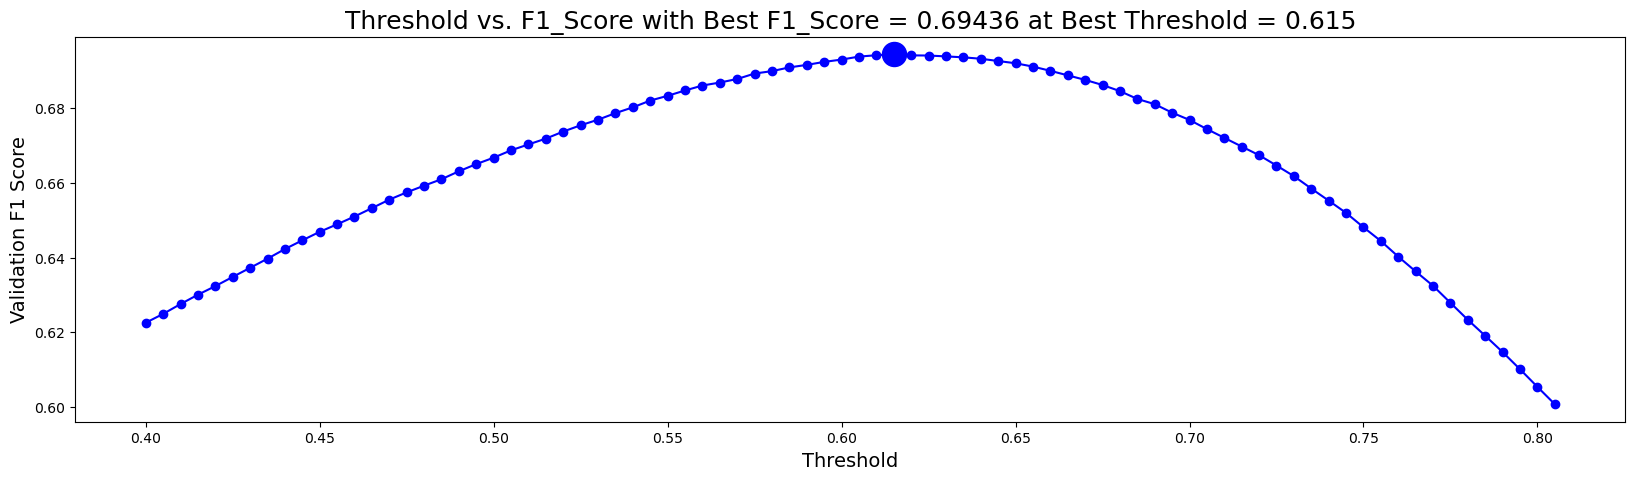

In [21]:
true = oof_xgb.copy()
for i in range(1, 19):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q==i].set_index('session').loc[ALL_USERS]
    true[f'meta_{i}'] = tmp.correct.values

# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score_xgb = 0; best_threshold_xgb = 0

for threshold in np.arange(0.4,0.81,0.005):
    print(f'{threshold:.03f}, ',end='')
    preds = (oof_xgb.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score_xgb:
        best_score_xgb = m
        best_threshold_xgb = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
plt.show()

In [22]:
%%time
clfs = {}
# ITERATE THRU QUESTIONS 1 THRU 18
for t in range(1,19):

    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1
        FEATURES = FEATURES1
    elif t<=13: 
        grp = '5-12'
        df = df2
        FEATURES = FEATURES2 
    elif t<=22: 
        grp = '13-22'
        df = df3
        FEATURES = FEATURES3
    
    n_estimators = int(np.median(best_iteration_xgb[str(t)]) + 1)
    xgb_params = {
        'objective': 'binary:logistic',
        'tree_method': 'gpu_hist',
        'eval_metric':'logloss',
        'learning_rate': 0.02,
        'alpha': 8,
        'max_depth': 4,
        'n_estimators': n_estimators,
        'subsample':0.8,
        'colsample_bytree': 0.5,
        'use_label_encoder': False
    }
    
    print('#'*25)
    print(f'### question {t} features {len(FEATURES)}')
        
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # TRAIN MODEL        
    clf =  XGBClassifier(**xgb_params)
    clf.fit(df[FEATURES].astype('float32'), train_y['correct'], verbose=0)
    clf.save_model(f'XGB_question{t}.json')
    clfs[t] = clf
    print()

#########################
### question 1 features 986

#########################
### question 2 features 986

#########################
### question 3 features 986

#########################
### question 4 features 1610

#########################
### question 5 features 1610

#########################
### question 6 features 1610

#########################
### question 7 features 1610

#########################
### question 8 features 1610

#########################
### question 9 features 1610

#########################
### question 10 features 1610

#########################
### question 11 features 1610

#########################
### question 12 features 1610

#########################
### question 13 features 1610

#########################
### question 14 features 1865

#########################
### question 15 features 1865

#########################
### question 16 features 1865

#########################
### question 17 features 1865

#########################
### question 18 f

In [23]:
import pickle

In [24]:
importance_dict = {}
for t in range(1, 19):
    if t<=3: 
        importance_dict[str(t)] = FEATURES1
    elif t<=13: 
        importance_dict[str(t)] = FEATURES2
    elif t<=22:
        importance_dict[str(t)] = FEATURES3
f_save = open('importance_dict.pkl', 'wb')
pickle.dump(importance_dict, f_save)
f_save.close()

In [25]:
import jo_wilder
jo_wilder.make_env.__called__ = False
env = jo_wilder.make_env()
type(env)._state = type(type(env)._state).__dict__['INIT']
iter_test = env.iter_test()
from collections import defaultdict
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}
# Remember to change the threshold
best_threshold = 0.625
preds = {}
historical_meta = defaultdict(list)

for (sample_submission, test) in iter_test:
    grp = test.level_group.values[0]
    session_id = test.session_id.values[0]
    session_id_2 = sample_submission.iloc[0, :]['session_id'].split('_')[0]
    if session_id_2 not in preds.keys():
        preds[session_id_2] = {}
    test = (pl.from_pandas(test)
          .drop(["fullscreen", "hq", "music"])
          .with_columns(columns))
    test=test.with_columns((pl.col('event_name') + '_' + pl.col('main_room')).alias('room_event'))

    # FEATURE ENGINEER TEST DATA
    test = feature_engineer(test, grp, use_extra=False)
    if grp == '5-12':
        for i in range(1,4):
            test[i] = preds[session_id_2][i]
    elif grp == '13-22':
        for i in range(1,14):
            test[i] = preds[session_id_2][i]
    # INFER TEST DATA
    a,b = limits[grp]
    for t in range(a, b):
        FEATURES = importance_dict[str(t)]
        if grp =='5-12':
            FEATURES = FEATURES+[i for i in range(1,4)]
        elif grp =='13-22':
            FEATURES = FEATURES+[i for i in range(1,14)]
        p = clfs[t].predict_proba(test[FEATURES].astype('float32'))[:,1]
        preds[session_id_2][t] = p
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


TypeError: feature_engineer() got an unexpected keyword argument 'use_extra'

In [ ]:
feature_importance_df

In [ ]:
import seaborn as sns
sns.displot(df1['n_level_shift_negative'])

In [ ]:
df1.n_level_shift_negative.min()

In [ ]:
x = df.select([pl.col('session_id'),pl.col('level'),pl.col('level').shift(1).alias('level_shift')]).filter(pl.col('session_id')==20090312431273200)

In [ ]:
x = x.with_columns((pl.col('level')-pl.col('level_shift')).alias('level_diff'))

In [ ]:
x.filter(pl.col('level_diff')<0)

In [ ]:
df1.filter((pl.col('session_id')==20090312431273200) & (pl.col('level_shift')<0))

In [ ]:
df1